In [23]:
import os
import re
import cv2
import numpy as np
import pandas as pd

def load_chest_xray(base_dir='chest_xray',
                    splits=('train','test','val'),
                    labels=('NORMAL','PNEUMONIA'),
                    target_size=None,    # (width,height) o None para mantener tamaño
                    load_images=True,    # False -> solo metadata y rutas
                    max_per_folder=None  # límite por carpeta (útil para tests)
                   ):
    """
    Devuelve un dict {split: DataFrame} con columnas:
      path, split, label, infection (virus/bacteria/None), person_id (int|None), image (ndarray|None)
    """
    rows_by_split = {s: [] for s in splits}
    person_re = re.compile(r'person(\d+)', re.IGNORECASE)

    for split in splits:
        for label in labels:
            folder = os.path.join(base_dir, split, label)
            if not os.path.isdir(folder):
                continue
            files = [f for f in os.listdir(folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
            if max_per_folder:
                files = files[:max_per_folder]
            for fname in files:
                path = os.path.join(folder, fname)
                image = None
                if load_images:
                    im = cv2.imread(path)
                    if im is None:
                        print(f"Warning: no se pudo leer {path}")
                        continue
                    # convertir a gris si se desea manteniendo comportamiento anterior
                    if len(im.shape) == 3:
                        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                    if target_size:
                        im = cv2.resize(im, target_size, interpolation=cv2.INTER_AREA)
                    image = im
                # detectar bacteria/virus en el nombre
                fn = fname.lower()
                infection = None
                if 'virus' in fn:
                    infection = 'virus'
                elif 'bacteria' in fn or 'bacterial' in fn:
                    infection = 'bacteria'
                # extraer person id si existe en el filename (p.ej. person78_...)
                m = person_re.search(fname)
                person_id = int(m.group(1)) if m else None

                rows_by_split[split].append({
                    'path': path,
                    'split': split,
                    'label': label,
                    'infection': infection,
                    'person_id': person_id,
                    'image': image
                })

    # convertir a DataFrames y mostrar resumen
    dfs = {}
    for s, rows in rows_by_split.items():
        if rows:
            df = pd.DataFrame(rows)
            dfs[s] = df
            print(f"{s}: leidas {len(df)} imágenes")
            print(df.groupby(['label']).size())
        else:
            print(f"{s}: carpeta no encontrada o vacía")
            dfs[s] = pd.DataFrame(columns=['path','split','label','infection','person_id','image'])

    return dfs


In [24]:
dfs = load_chest_xray(target_size=(224,224), load_images=True)
train_df = dfs.get('train')
test_df  = dfs.get('test')
val_df   = dfs.get('val')

train: leidas 5216 imágenes
label
NORMAL       1341
PNEUMONIA    3875
dtype: int64
test: leidas 624 imágenes
label
NORMAL       234
PNEUMONIA    390
dtype: int64
val: leidas 16 imágenes
label
NORMAL       8
PNEUMONIA    8
dtype: int64


NORMAL — chest_xray\train\NORMAL\NORMAL2-IM-1142-0001.jpeg


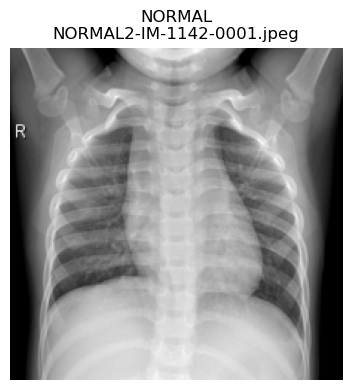

Neumonía virus — person1000.0 — 2 imágenes


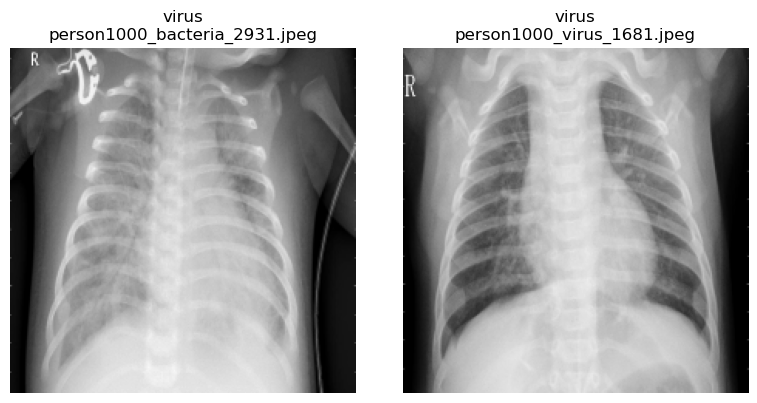

Neumonía bacteria — person1000.0 — 2 imágenes


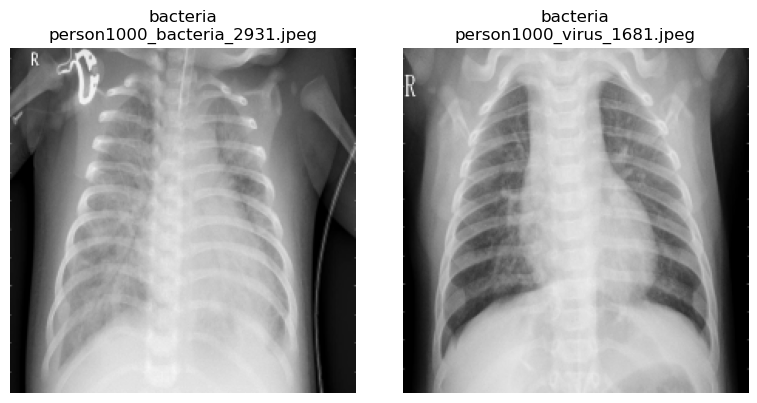

In [26]:
import math
def _load_img_from_row(row):
    if 'image' in row and row['image'] is not None:
        return row['image']
    im = cv2.imread(row['path'])
    if im is None:
        raise FileNotFoundError(row['path'])
    # si es color, convertir a gris para compatibilidad con el resto del pipeline
    if len(im.shape) == 3:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return im

def show_grid(images, titles=None, max_cols=4, cmap='gray', figsize_per_img=(4,4)):
    n = len(images)
    if n == 0:
        print("No hay imágenes para mostrar.")
        return
    cols = min(max_cols, n)
    rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(figsize_per_img[0]*cols, figsize_per_img[1]*rows))
    axes = np.array(axes).reshape(-1)
    for i, ax in enumerate(axes):
        if i < n:
            im = images[i]
            ax.imshow(im, cmap=cmap)
            if titles and i < len(titles):
                ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Asume que train_df existe (creado por load_chest_xray)
if 'train_df' not in globals() or train_df is None:
    print("train_df no encontrado. Ejecuta la celda que carga el dataset antes.")
else:
    # 1) una imagen NORMAL aleatoria
    normals = train_df[train_df['label']=='NORMAL']
    if len(normals):
        sample = normals.sample(1).iloc[0]
        img = _load_img_from_row(sample)
        print("NORMAL —", sample['path'])
        show_grid([img], [f"NORMAL\n{sample['path'].split(os.sep)[-1]}"], max_cols=1)
    else:
        print("No hay imágenes NORMAL en train_df.")

    # 2) neumonía por virus: elegir un person_id que exista y mostrar todas sus imágenes
    virus_rows = train_df[(train_df['label']=='PNEUMONIA') & (train_df['infection']=='virus') & (train_df['person_id'].notnull())]
    if len(virus_rows):
        pid = virus_rows['person_id'].iloc[0]
        person_imgs_rows = train_df[(train_df['person_id']==pid) & (train_df['label']=='PNEUMONIA')]
        imgs = []
        titles = []
        for _, r in person_imgs_rows.iterrows():
            imgs.append(_load_img_from_row(r))
            titles.append(f"virus\n{r['path'].split(os.sep)[-1]}")
        print(f"Neumonía virus — person{pid} — {len(imgs)} imágenes")
        show_grid(imgs, titles)
    else:
        print("No hay ejemplos de neumonía por virus con person_id en train_df.")

    # 3) neumonía por bacteria: idem
    bact_rows = train_df[(train_df['label']=='PNEUMONIA') & (train_df['infection']=='bacteria') & (train_df['person_id'].notnull())]
    if len(bact_rows):
        pid = bact_rows['person_id'].iloc[0]
        person_imgs_rows = train_df[(train_df['person_id']==pid) & (train_df['label']=='PNEUMONIA')]
        imgs = []
        titles = []
        for _, r in person_imgs_rows.iterrows():
            imgs.append(_load_img_from_row(r))
            titles.append(f"bacteria\n{r['path'].split(os.sep)[-1]}")
        print(f"Neumonía bacteria — person{pid} — {len(imgs)} imágenes")
        show_grid(imgs, titles)
    else:
        print("No hay ejemplos de neumonía por bacteria con person_id en train_df.")
